# Part A: Run Following Section for Needed Functions

In [28]:
!pip install --upgrade --no-cache-dir gdown
!pip install pytorch_lightning &> /dev/null
!gdown 1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
!gdown 1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
!gdown 1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
!gdown 1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
To: /content/hw3_mycocodata_mask_comp_zlib.h5
100% 4.30M/4.30M [00:00<00:00, 71.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
To: /content/hw3_mycocodata_labels_comp_zlib.npy
100% 269k/269k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
To: /content/hw3_mycocodata_img_comp_zlib.h5
100% 801M/801M [00:08<00:00, 94.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
To: /content/hw3_mycocodata_bboxes_comp_zlib.npy
100% 327k/327k [00:00<00:00, 83.3MB/s]


In [29]:
from sklearn import metrics
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from inspect import modulesbyfile
from tqdm import tqdm
import h5py
import albumentations as A
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
torch.set_printoptions(linewidth=100)

np.set_printoptions(linewidth=100)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def Resnet50Backbone(checkpoint_file=None, device="cuda", eval=True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)

    if eval == True:
        model.eval()

    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    resnet50_fpn = model.backbone

    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)

        resnet50_fpn.load_state_dict(checkpoint['backbone'])

    return resnet50_fpn

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_fpn = Resnet50Backbone()
# backbone = Resnet50Backbone('checkpoint680.pth')
E = torch.ones([2,3,800,1088], device=device)
backout = resnet50_fpn(E)
print(backout.keys())
print(backout["0"].shape)
print(backout["1"].shape)
print(backout["2"].shape)
print(backout["3"].shape)
print(backout["pool"].shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

odict_keys(['0', '1', '2', '3', 'pool'])
torch.Size([2, 256, 200, 272])
torch.Size([2, 256, 100, 136])
torch.Size([2, 256, 50, 68])
torch.Size([2, 256, 25, 34])
torch.Size([2, 256, 13, 17])


In [ ]:
def xyxy_xywh(coords, to_wh=False):
  if to_wh:
    fincord=[]
    for asc in range(len(coords)):
      newcoords = torch.zeros(coords.shape)
      xl  = coords[asc][:,:,0]
      yl  = coords[asc][:,:,1]
      xr  = coords[asc][:,:,2]
      yr  = coords[asc][:,:,3]

      newcoords[:,:,2] = xr - xl
      newcoords[:,:,3] = yr - yl
      newcoords[:,:,0] = xl + newcoords[:,:,2]/2
      newcoords[:,:,1] = yl + newcoords[:,:,3]/2
      fincord.append(newcoords)

    fincord= torch.stack((fincord)) 
    return fincord

  else:
    fincord=[]
    for asc in range(len(coords)):
      newcoords = torch.zeros(coords[asc].shape)
      cx  = coords[asc][:,:,0]
      cy  = coords[asc][:,:,1]
      w  = coords[asc][:,:,2]
      h  = coords[asc][:,:,3]

      newcoords[:,:,0] = cx - w/2
      newcoords[:,:,1] = cy - h/2
      newcoords[:,:,2] = cx + w/2 
      newcoords[:,:,3] = cy + h/2
      fincord.append(newcoords)
    
    fincord= torch.stack((fincord))
    return fincord

def IOU(tar1, tar2):
    ##################################
    #TODO compute the IOU between the boxA, boxB boxes
    ##################################
    xl_int = torch.maximum(tar1[0], tar2[0])
    yl_int = torch.maximum(tar1[1], tar2[1])
    xr_int = torch.minimum(tar1[2], tar2[2])
    yr_int = torch.minimum(tar1[3], tar2[3])
    Area_of_int = torch.maximum(torch.Tensor([0]).to(device), xr_int - xl_int) * torch.maximum(torch.Tensor([0]).to(device), yr_int - yl_int)
    Area_of_union = (torch.abs(tar1[2] - tar1[0]) * torch.abs(tar1[3] - tar1[1])) + (torch.abs(tar2[2] - tar2[0]) * torch.abs(tar2[3] - tar2[1])) - Area_of_int
    return Area_of_int/(Area_of_union+1e-6)

In [82]:
class RPNHead(pl.LightningModule):
    def __init__(self, num_anchors=3, in_channels=256,
                 anchors_param=dict(ratio=[[1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2]],
                                    scale=[32, 64, 128, 256, 512],
                                    grid_size=[(200, 272), (100, 136), (50, 68), (25, 34), (13, 17)],
                                    stride=[4, 8, 16, 32, 64])):
        super(RPNHead,self).__init__()
        ######################################
        # TODO initialize RPN
        #######################################
        self.loss_sum=0
        self.closs_sum=0
        self.rloss_sum=0
        self.epoch_loss=[]
        self.val_epoch_loss=[]
        self.epoch_closs=[]
        self.val_epoch_closs=[]
        self.epoch_rloss=[]
        self.val_epoch_rloss=[]
        self.lr =  0.01

        self.bceloss = nn.BCELoss(reduction ='sum')
        self.smoothl1 = nn.SmoothL1Loss(reduction ='sum')
          
        # TODO  Define Intermediate Layer
        self.intermediate_layer =  nn.Sequential(
            # Convolution 1
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),   
        )

        # TODO  Define Proposal Classifier Head
        self.classhead= nn.Sequential(nn.Conv2d(256, 3, kernel_size=(1,1), stride=1, padding='same'),  nn.Sigmoid())

        # TODO Define Proposal Regressor Head
        self.reghead= nn.Sequential(nn.Conv2d(256, 12, kernel_size=(1,1), stride=1, padding='same'),  nn.Sigmoid())
    
        #  find anchors
        self.anchors_param=anchors_param
        self.anchors=self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'],self.anchors_param['grid_size'],self.anchors_param['stride'])
        self.ground_dict= {}
        self.backbone = Resnet50Backbone()
        
    # Forward each level of the FPN output through the intermediate layer and the RPN heads
    # Input:
    #       X: list:len(FPN){(bz,256,grid_size[0],grid_size[1])}
    # Ouput:
    #       logits: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
    #       bbox_regs: list:len(FPN){(bz,4*num_anchors, grid_size[0],grid_size[1])}
    def forward(self, images):
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        logits=[]
        bbox_regs=[]
        for i in range(len(feature_pyramid)):
          pyram= feature_pyramid[i]
          intermediate= self.intermediate_layer(pyram)

          class_out= self.classhead(intermediate)
          reg_out= self.reghead(intermediate)

          logits.append(class_out)
          bbox_regs.append(reg_out)
        return logits, bbox_regs

    # This function creates the anchor boxes for all FPN level
    # Input:
    #       aspect_ratio: list:len(FPN){list:len(number_of_aspect_ratios)}
    #       scale:        list:len(FPN)
    #       grid_size:    list:len(FPN){tuple:len(2)}
    #       stride:        list:len(FPN)
    # Output:
    #       anchors_list: list:len(FPN){(grid_size[0]*grid_size[1]*num_anchors,4)}
    def create_anchors(self, aspect_ratio, scale, grid_size, stride):
        anchors_list = []
        for lev in range(len(scale)):
          anchors_list.append(self.create_anchors_single(aspect_ratio[lev], scale[lev], grid_size[lev], stride[lev]))
        return anchors_list

    # This function creates the anchor boxes for one FPN level
    # Input:
    #      aspect_ratio: list:len(number_of_aspect_ratios)
    #      scale: scalar
    #      grid_size: tuple:len(2)
    #      stride: scalar
    # Output:
    #       anchors: (grid_size[0]*grid_size[1]*num_acnhors,4)
    def create_anchors_single(self, aspect_ratio, scale, grid_sizes, stride):
        ######################################
        # TODO create anchors
        ######################################
        anchors=[]
        for aspec in aspect_ratio:
          h= scale/(aspec**0.5)
          w= aspec * h
          # print(h,w, aspec, grid_sizes)
          wst = torch.ones((grid_sizes[0], grid_sizes[1])) * w
          hst = torch.ones((grid_sizes[0], grid_sizes[1])) * h

          xs = torch.linspace(0, grid_sizes[0]-1, steps=grid_sizes[0])
          ys = torch.linspace(0, grid_sizes[1]-1, steps=grid_sizes[1])
          x_, y_ = torch.meshgrid(ys, xs, indexing='xy') 
          x = x_ * stride
          y = y_ * stride
          cx =  x+8
          cy =  y+8

          single_anchors = torch.stack((cx, cy, wst, hst))
          single_anchors = torch.permute(single_anchors, (1, 2, 0))
          assert single_anchors.shape == (grid_sizes[0] , grid_sizes[1],4)

          anchors.append(single_anchors)

        anchors = torch.stack((anchors))   #.reshape(grid_sizes[0]*grid_sizes[1]*len(aspect_ratio),4)
        assert anchors.shape == (len(aspect_ratio),grid_sizes[0], grid_sizes[1],4)

        return anchors.to(device)  

    def get_anchors(self):
        return self.anchors

    # This function creates the ground truth for a batch of images
    # Input:
    #      bboxes_list: list:len(bz){(number_of_boxes,4)}
    #      indexes: list:len(bz)
    #      image_shape: list:len(bz){tuple:len(2)}
    # Ouput:
    #      ground_clas: list:len(FPN){(bz,num_anchors,grid_size[0],grid_size[1])}
    #      ground_coord: list:len(FPN){(bz,4*num_anchors,grid_size[0],grid_size[1])}
    def create_batch_truth(self, bboxes_list, indexes, image_shape):
        ground_clas = [[],[],[],[],[]]
        ground_coord= [[],[],[],[],[]]
        for i in range(len(bboxes_list)):
          gclass_i, gcoord_i = self.create_ground_truth(bboxes_list[i].to(device), indexes[i], self.anchors_param['grid_size'], self.anchors, image_shape) 
          for lev in range(len(gclass_i)):
            ground_clas[lev].append(gclass_i[lev])
            ground_coord[lev].append(gcoord_i[lev])

        for lev in range(len(ground_coord)):
          ground_clas[lev]  = torch.stack(ground_clas[lev])
          ground_coord[lev] = torch.stack(ground_coord[lev])
  
        return ground_clas, ground_coord

    # This function create the ground truth for one image for all the FPN levels
    # It also caches the ground truth for the image using its index
    # Input:
    #       bboxes:      (n_boxes,4)
    #       index:       scalar (the index of the image in the total dataset)
    #       grid_size:   list:len(FPN){tuple:len(2)}
    #       anchor_list: list:len(FPN){(num_anchors*grid_size[0]*grid_size[1],4)}
    # Output:
    #       all_ground_clas: list:len(FPN){(num_anchors,grid_size[0],grid_size[1])}
    #       all_ground_coord: list:len(FPN){(4*num_anchors,grid_size[0],grid_size[1])}
    def create_ground_truth(self, bboxes, index, grid_sizes, anchor_list, image_size):
        key = str(index)
        if key in self.ground_dict:
            ground_clas, ground_coord = self.ground_dict[key]
            return ground_clas, ground_coord
        
        all_ground_clas = []
        all_ground_coord = []
        ############################# TODO ### LOOK AT SQUEEZE INSTEAD OF RESHAPE#######################################################################
        for lev in range(len(grid_sizes)):
          grid_size = grid_sizes[lev]
          anchorsall = anchor_list[lev]
          anchorswhall= torch.permute(anchorsall, (0, 3, 1, 2)).to(device)
          anchorsall = xyxy_xywh(anchorsall, to_wh=False).to(device)
          
          fpn_ground_clas = []
          fpn_ground_coord = []

          for tpe in range(len(anchorsall)):
            anchorswh = anchorswhall[tpe]
            anchors =  anchorsall[tpe]
           
            ground_clas =  torch.zeros(grid_size[0],grid_size[1]).to(device)
            ground_coord =  torch.zeros(4,grid_size[0],grid_size[1]).to(device)
            idx0  = torch.unique((anchors<0).nonzero()[:,:2], dim=0)
            idx1  = (anchors[:,:,3]>800).nonzero()
            idx2  = (anchors[:,:,2]>1088).nonzero()
            idx = torch.unique(torch.vstack((idx0, idx1, idx2)), dim =0)
            ground_clas[idx[:,0], idx[:,1]] = -1

            ious = []
            idxs_noneg = torch.ones((grid_size[0],grid_size[1]), dtype=torch.bool).to(device)
            for nbo in range(len(bboxes)):
              boxB = bboxes[nbo].clone()
              temp = torchvision.ops.box_iou(torch.unsqueeze(boxB,0), anchors.reshape(-1,4)).reshape(grid_size[0],grid_size[1])
              ious.append(temp)
              idxs_noneg = torch.logical_and(idxs_noneg, torch.logical_and((temp>0.3), (temp<0.7)))
            ious = torch.stack(ious)
            
            ground_clas[idxs_noneg] = -1   ##HAD COMENTED OUT AND WORKED SO SEEE IF NEEDED

            for nbo in range(len(bboxes)): 
              boxB = bboxes[nbo].clone()
              w = boxB[2] - boxB[0]
              h = boxB[3] - boxB[1]
              cx = boxB[0] + w/2
              cy = boxB[1] + h/2
              boxB[:] = torch.Tensor([cx , cy, w, h]).to(device)

              boxBall = boxB.repeat(grid_size[1],grid_size[0],1).T.float()

              # Encoding
              tx = (boxBall[0,:, :] - anchorswh[0,:, :]) /  anchorswh[2,:, :]
              ty = (boxBall[1,:, :] - anchorswh[1,:, :]) /  anchorswh[3,:, :]
              tw = torch.log(boxBall[2,:, :]/anchorswh[2,:, :])
              th = torch.log(boxBall[3,:, :]/anchorswh[3,:, :])

              boxBall = torch.stack((tx, ty, tw, th))

              ground_clas[ious[nbo]>=0.7] = 1
              ground_coord[:, ious[nbo]>=0.7] = boxBall[:, ious[nbo]>=0.7]  
              maxiou = ious[nbo].max().item() - 0.0001
              ground_clas[ious[nbo]>=maxiou] = 1
              ground_coord[:, ious[nbo]>=maxiou] = boxBall[:, ious[nbo]>=maxiou]  
              ground_clas[ious[nbo]<0.3] = 0
              ground_coord[:, ious[nbo]<0.3] = boxBall[:, ious[nbo]<0.3]*0  

            ground_clas =  torch.unsqueeze(ground_clas, dim=0)
            fpn_ground_clas.append(ground_clas)
            fpn_ground_coord.append(ground_coord)
          
          all_ground_clas.append(torch.cat(fpn_ground_clas, 0))
          all_ground_coord.append(torch.cat(fpn_ground_coord, 0))
      
        # self.ground_dict[key] = (all_ground_clas, all_ground_coord)
        return all_ground_clas, all_ground_coord

    # Compute the loss of the classifier
    # Input:
    #      p_out:     (positives_on_mini_batch)  (output of the classifier for sampled anchors with positive gt labels)
    #      n_out:     (negatives_on_mini_batch) (output of the classifier for sampled anchors with negative gt labels
    def loss_class(self, p_out, n_out):
      loss_c = self.bceloss(n_out, torch.zeros((n_out.shape)).to(device)) + self.bceloss(p_out, torch.ones((p_out.shape)).to(device))
      return loss_c / self.nreg 

    # Compute the loss of the regressor
    # Input:
    #       pos_target_coord: (positive_on_mini_batch,4) (ground truth of the regressor for sampled anchors with positive gt labels)
    #       pos_out_r: (positive_on_mini_batch,4)        (output of the regressor for sampled anchors with positive gt labels)
    def loss_reg(self, pos_target_coord, pos_out_r):
      # TODO compute regressor's loss
      loss_r= self.smoothl1(pos_out_r, pos_target_coord)
      return loss_r / self.nreg 

    # Compute the total loss for the FPN heads
    # Input:
    #       clas_out_list: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
    #       regr_out_list: list:len(FPN){(bz,4*num_anchors,grid_size[0],grid_size[1])}
    #       targ_clas_list: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
    #       targ_regr_list: list:len(FPN){(bz,4*num_anchors,grid_size[0],grid_size[1])}
    #       l: weighting lambda between the two losses
    # Output:
    #       loss_c: scalar
    #       loss_r: scalar
    def compute_loss(self, clas_out, regr_out, targ_clas, targ_regr, l=5, effective_batch=150):
      pos_idx = (targ_clas == 1).nonzero()
      neg_idx = (targ_clas == 0).nonzero()

      if len(pos_idx)>(effective_batch/2):
        rand_idx = torch.randperm(len(pos_idx))[:int(effective_batch/2)]
        sampled_pos_idx = pos_idx[rand_idx]
        rand_idx = torch.randperm(len(neg_idx))[:int(effective_batch/2)]
        sampled_neg_idx = neg_idx[rand_idx]
      else:
        sampled_pos_idx = pos_idx
        rand_idx = torch.randperm(len(neg_idx))[:effective_batch - len(pos_idx)]
        sampled_neg_idx = neg_idx[rand_idx]

      p_out = clas_out[sampled_pos_idx]
      n_out = clas_out[sampled_neg_idx]
      self.nreg =  len(p_out) + len(n_out)
      loss_c = self.loss_class(p_out,n_out)

      pos_target_coord = torch.squeeze(targ_regr[sampled_pos_idx, :])
      pos_out_r = torch.squeeze(regr_out[sampled_pos_idx, :])
      loss_r = self.loss_reg(pos_target_coord,pos_out_r)
      return loss_c, l*loss_r

    def training_step(self, batch, batch_idx):
      images, labels, bbox, masks, index = batch

      logits, regout  = self.forward(images.to(device).float())
      gt,ground_coord=self.create_batch_truth(bbox,index,images.shape[-2:])
      
      regr_out, clas_out, _= output_flattening(regout, logits, self.get_anchors())
      targ_regr, targ_clas, _ = output_flattening(ground_coord, gt, self.get_anchors())

      l1, l2 = self.compute_loss(clas_out, regr_out, targ_clas, targ_regr)
      loss = l1+l2

      self.closs_sum = self.closs_sum + l1.item()
      self.rloss_sum = self.rloss_sum + l2.item()
      self.loss_sum = self.loss_sum + loss.item()

      self.log("train_loss", loss, prog_bar = True)
      if batch_idx==(batch_tr-1):
        self.epoch_loss.append(self.loss_sum/batch_tr)
        self.epoch_closs.append(self.closs_sum/batch_tr)
        self.epoch_rloss.append(self.rloss_sum/batch_tr)
        print("Training")
        print("total loss: ",self.epoch_loss)
        print("closs: ", self.epoch_closs)
        print("rloss: ", self.epoch_rloss)
        self.loss_sum=0
        self.closs_sum=0
        self.rloss_sum=0
      return loss

    def validation_step(self, batch, batch_idx):
      images, labels, bbox, masks, index = batch

      logits, regout  = self.forward(images.to(device).float())
      gt,ground_coord=self.create_batch_truth(bbox,index,images.shape[-2:])
      
      regr_out, clas_out, _= output_flattening(regout, logits, self.get_anchors())
      targ_regr, targ_clas, _ = output_flattening(ground_coord, gt, self.get_anchors())

      l1, l2 = self.compute_loss(clas_out, regr_out, targ_clas, targ_regr)
      loss = l1+l2

      self.closs_sum = self.closs_sum + l1.item()
      self.rloss_sum = self.rloss_sum + l2.item()
      self.loss_sum = self.loss_sum + loss.item()
      
      self.log("val_loss", loss, prog_bar = True)

      if batch_idx==(batch_val-1):
        self.val_epoch_loss.append(self.loss_sum/batch_val)
        self.val_epoch_closs.append(self.closs_sum/batch_val)
        self.val_epoch_rloss.append(self.rloss_sum/batch_val)
        print("Validation")
        print("total loss: ", self.val_epoch_loss)
        print("closs: ", self.val_epoch_closs)
        print("rloss: ", self.val_epoch_rloss)

        self.loss_sum=0
        self.closs_sum=0
        self.rloss_sum=0
  
      return loss

    def configure_optimizers(self):
      optim = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
      lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, [10, 20, 30], gamma=0.1)
      return {"optimizer": optim, "lr_scheduler": lr_scheduler}

    # Post process for the outputs for a batch of images
    # Input:
    #       out_c:  (bz,1,grid_size[0],grid_size[1])}
    #       out_r:  (bz,4,grid_size[0],grid_size[1])}
    #       IOU_thresh: scalar that is the IOU threshold for the NMS
    #       keep_num_preNMS: number of masks we will keep from each image before the NMS
    #       keep_num_postNMS: number of masks we will keep from each image after the NMS
    # Output:
    #       nms_clas_list: list:len(bz){(Post_NMS_boxes)} (the score of the boxes that the NMS kept)
    #       nms_prebox_list: list:len(bz){(Post_NMS_boxes,4)} (the coordinates of the boxes that the NMS kept)
    def topK_plotter(self,images, bbbox, topK=20):
      ####################################
      # TODO postprocess a batch of images
      #####################################
      logits, reg_bbox  = self.forward(images.float())
      flatten_bbox, flatten_clas, flatten_anchors= output_flattening(reg_bbox, logits, self.get_anchors())
      decoded_coord=output_decoding(flatten_bbox,flatten_anchors).to(device)

      sorted_score, sorted_idx = torch.sort(flatten_clas, descending = True)
      sorted_idx = sorted_idx[:topK].to(device)
      topK_score = sorted_score[sorted_idx]
      topK_bbox = decoded_coord[sorted_idx]  
      # Plotting
      img=images[0].cpu().numpy()
      x_min = img.min(axis=(1, 2), keepdims=True)
      x_max = img.max(axis=(1, 2), keepdims=True)
      img = (img - x_min)/(x_max-x_min)
      fig,ax=plt.subplots(1,1)
      ax.imshow(np.transpose(img, axes=(1,2,0)))
      for elem in topK_bbox:
          coord=elem.cpu().detach().numpy()
          coord[0] =  np.clip(coord[0], 0, 1088)
          coord[2] =  np.clip(coord[2], 0, 1088)
          coord[1] =  np.clip(coord[1], 0, 800)
          coord[3] =  np.clip(coord[3], 0, 800)
          rect=Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color='r')
          ax.add_patch(rect)
      for box in bbbox:
        rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b', linewidth=2)
        ax.add_patch(rect)

      plt.show()
      return topK_bbox

    def nms_plotter(self,images, bbbox, keep_num_preNMS, keep_num_postNMS):
      ####################################
      # TODO postprocess a batch of images
      #####################################
      logits, reg_bbox = model.forward(images.float())
      nms_clas, nms_prebox= self.postprocessImg(logits,reg_bbox, 0.5, keep_num_preNMS, keep_num_postNMS)

      # Plotting Post NMS
      img=images[0].cpu().numpy()
      x_min = img.min(axis=(1, 2), keepdims=True)
      x_max = img.max(axis=(1, 2), keepdims=True)
      img = (img - x_min)/(x_max-x_min)
      fig,ax=plt.subplots(1,1)
      ax.imshow(np.transpose(img, axes=(1,2,0)))
      for elem in nms_prebox:
          coord=elem.detach().cpu().numpy()
          col='r'
          rect=Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
          ax.add_patch(rect)
      for box in bbbox:
        rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='b', linewidth=2)
        ax.add_patch(rect)
      plt.show()
      return nms_prebox
         
    def non_max_suppression(self, bbox, score):
        prs= score
        all_lab= bbox
        for i in range(len(all_lab)):
          tar1= torch.unsqueeze(all_lab[i],0)
          for j in range(i+1,len(all_lab)):
            tar2=torch.unsqueeze(all_lab[j],0)
            iou= torchvision.ops.box_iou(tar2, tar1)[0]
            if iou>=0.4:
              if prs[i]>prs[j]:
                all_lab[j,:]=0
                prs[j] = 0
              else:
                all_lab[i,:]=0 
                prs[i] = 0
        return prs, all_lab

    # Post process the output for one image
    # Input:
    #      mat_clas: (1,grid_size[0],grid_size[1])}  (scores of the output boxes)
    #      mat_coord: (4,grid_size[0],grid_size[1])} (encoded coordinates of the output boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4) (decoded coordinates of the boxes that the NMS kept)
    def postprocessImg(self,mat_clas,mat_coord, IOU_thresh,keep_num_preNMS, keep_num_postNMS):
      ######################################
      # TODO postprocess a single image
      #####################################
      keep_num_preNMS = 2000
      # nms_prebox = 1
      flatten_bbox,flatten_clas,flatten_anchors=output_flattening(mat_coord,mat_clas,self.get_anchors()) 
      decoded_coord=output_decoding(flatten_bbox,flatten_anchors).to(device)

      # top k boxes - sort thres_clas,  keep top k
      sorted_score, sorted_idx = torch.sort(flatten_clas, descending = True)
      sorted_idx = sorted_idx[:keep_num_preNMS].to(device)
      topK_score = sorted_score[sorted_idx]
      topK_bbox = decoded_coord[sorted_idx]
      
      # nms_clas, nms_prebox = self.non_max_suppression(topK_bbox, topK_score)
      scores = MatrixNMS(topK_bbox.to(device), topK_score.to(device))
      top_scores, top5kidx = torch.sort(scores, descending=True)
      top_scores =top_scores[0 : keep_num_postNMS]
      topboxes = topK_bbox[0 : keep_num_postNMS]

      # final_idx = (nms_clas).nonzero()

      # nms_clas = nms_clas[final_idx]
      # nms_prebox = nms_prebox[final_idx]
      # call nms for top N bbox with thres = keep_num_postNMS ???? 
      # decode the remaining boxes which would be decoded
      return top_scores, topboxes

    def IoU_NMS(self, tar1, tar2): 
      tar1[0] =  torch.clip(tar1[0], 0, 1088)
      tar1[2] =  torch.clip(tar1[2], 0, 1088)
      tar1[1] =  torch.clip(tar1[1], 0, 800)
      tar1[3] =  torch.clip(tar1[3], 0, 800)

      tar2[0] =  torch.clip(tar2[0], 0, 1088)
      tar2[2] =  torch.clip(tar2[2], 0, 1088)
      tar2[1] =  torch.clip(tar2[1], 0, 800)
      tar2[3] =  torch.clip(tar2[3], 0, 800) 
      xl_int = torch.maximum(tar1[0], tar2[0])
      yl_int = torch.maximum(tar1[1], tar2[1])
      xr_int = torch.minimum(tar1[2], tar2[2])
      yr_int = torch.minimum(tar1[3], tar2[3])
      Area_of_int = torch.maximum(torch.Tensor([0]).to(device), xr_int - xl_int) * torch.maximum(torch.Tensor([0]).to(device), yr_int - yl_int)
      Area_of_union = (torch.abs(tar1[2] - tar1[0]) * torch.abs(tar1[3] - tar1[1])) + (torch.abs(tar2[2] - tar2[0]) * torch.abs(tar2[3] - tar2[1])) - Area_of_int
      return Area_of_int/(Area_of_union+1e-13)


In [ ]:
def vizualise_dataloader(images, labels, bbox, masks):
  c=['none', 'green', 'blue','red']
  cc=['none', 'g', 'b','r']
  cl=['none', 'Vehicle', 'Person','Animal']
  for i in range(len(images)):
    img, label, bbox_, mask_ = images[i], labels[i], bbox[i], masks[i]
    img=img.numpy()
    x_min = img.min(axis=(1, 2), keepdims=True)
    x_max = img.max(axis=(1, 2), keepdims=True)
    img = (img - x_min)/(x_max-x_min)
    plt.imshow(np.transpose(img, axes=(1,2,0)))
    for j in range(len(bbox_)):
      plt.imshow(np.squeeze(mask_[j].numpy()), cmap=ListedColormap(['none', c[label[j]]]), alpha=.3)
      xl, yl, xr, yr = bbox_[j].numpy()
      plt.gca().add_patch(Rectangle((xl,yl),(xr-xl),(yr-yl),linewidth=1,edgecolor=cc[label[j]],facecolor='none'))
      plt.text(xl+0.25, yl+0.25, cl[label[j]], color='y')

    plt.show()

In [ ]:
def load_datset(viz):
  labels_og = np.load("hw3_mycocodata_labels_comp_zlib.npy", allow_pickle=True, encoding='latin1')
  bbox_og = np.load("hw3_mycocodata_bboxes_comp_zlib.npy", allow_pickle=True, encoding='latin1')
  imgs = h5_to_npy("hw3_mycocodata_img_comp_zlib.h5") 
  masks_og = h5_to_npy("hw3_mycocodata_mask_comp_zlib.h5")

  # Testing if Files have been sucessfully loaded
  if viz:
    c=['none', 'green', 'blue','yellow']
    counter = []
    for l in labels_og:
      counter.append(len(l))
    for i in range(5):
      img_o=np.transpose(imgs[i], axes=(1,2,0))
      plt.imshow(img_o)
      maskstart= int(np.sum(counter[:i]))
      for num in range(maskstart, maskstart+len(labels_og[i]),1):
        plt.imshow(masks_og[num], cmap=ListedColormap([c[0], c[labels_og[i][num-maskstart]]]), alpha=.3)
        xl, yl, xr, yr = bbox_og[i][num-maskstart]
        plt.gca().add_patch(Rectangle((xl,yl),(xr-xl),(yr-yl),linewidth=1,edgecolor='r',facecolor='none'))
      plt.show()
  return labels_og, bbox_og, imgs, masks_og

In [ ]:
def viz_all_levels_all_asp(gt_, ground_coord_, images_, model): 
  for img_of_batch in range(batch_size):
    # Since we only want to plot one
    images=images_[img_of_batch,:,:,:]
    anchors_ = model.get_anchors()
    for lev in range(5):    
      gt = gt_[lev][img_of_batch]
      temp = ground_coord_[lev][img_of_batch]
      ground_coord = temp.reshape(3,4,temp.shape[-2],temp.shape[-1])
      anchors = anchors_[lev]

      img=images.numpy()
      x_min = img.min(axis=(1, 2), keepdims=True)
      x_max = img.max(axis=(1, 2), keepdims=True)
      img = (img - x_min)/(x_max-x_min)
      
      for asp in range(3):
        fig,ax=plt.subplots(1,1)
        ax.imshow(np.transpose(img, axes=(1,2,0)))
        gtas = gt[asp].view(-1)
        gcoas = torch.permute(ground_coord[asp],(1,2,0)).reshape(-1,4)
        ancas = anchors[asp].reshape(-1,4)
        decoded=output_decoding(gcoas,ancas)

        find_cor=(gtas==1).nonzero()
        for elem in find_cor:
            coord=decoded[elem,:].view(-1).cpu()
            anchor=ancas[elem,:].view(-1).cpu()

            rect=Rectangle((anchor[0]-anchor[2]/2,anchor[1]-anchor[3]/2),anchor[2],anchor[3],fill=False,color='b')
            ax.add_patch(rect)

            rect=Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color='r', linewidth=2)
            ax.add_patch(rect)
        plt.show()

In [ ]:
# This function flattens the output of the network and the corresponding anchors
# in the sense that it concatenate  the outputs and the anchors from all the grid cells from all
# the FPN levels from all the images into 2D matrices
# Each row correspond of the 2D matrices corresponds to a specific grid cell
# Input:
#       out_r: list:len(FPN){(bz,num_anchors*4,grid_size[0],grid_size[1])}
#       out_c: list:len(FPN){(bz,num_anchors*1,grid_size[0],grid_size[1])}
#       anchors: list:len(FPN){(num_anchors,grid_size[0]*grid_size[1],4)}
# Output:
#       flatten_regr: (total_number_of_anchors*bz,4)
#       flatten_clas: (total_number_of_anchors*bz)
#       flatten_anchors: (total_number_of_anchors*bz,4)
def output_flattening(out_r, out_c, anchors):
    bz = len(out_r[0])
    flatten_regr = []
    flatten_clas = []
    flatten_anchors = []
    for lev in range(len(out_r)):
      out_rl = torch.permute(out_r[lev],(0,2,3,1))
      out_cl = torch.permute(out_c[lev],(0,2,3,1))
      anchorl = torch.permute(anchors[lev], (1, 2, 0, 3)).reshape(out_rl.shape[1], out_rl.shape[2],12)
      anchorl =  anchorl.repeat(bz,1,1,1)

      
      flat_clasl = out_cl.reshape(-1,3)
      flat_regl = out_rl.reshape(-1, 12)
      flat_ancl = anchorl.reshape(-1,12)

      for an in range(0,12,4):
        flatten_regr.append(flat_regl[:, an:an+4])
        flatten_anchors.append(flat_ancl[:, an:an+4])
        flatten_clas.append(flat_clasl[:, an//4])
      
    flatten_regr = torch.concat(flatten_regr, 0)
    flatten_clas = torch.concat(flatten_clas, 0)
    flatten_anchors = torch.concat(flatten_anchors, 0)
    return flatten_regr, flatten_clas, flatten_anchors

In [65]:
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

In [ ]:
def viz_all_levels(gt_, ground_coord_, images_, model): 
  for img_of_batch in range(batch_size):
    images=images_[img_of_batch,:,:,:]
    anchors_ = model.get_anchors()

    for lev in range(5):
      gt = torch.unsqueeze(gt_[lev][img_of_batch],0)
      ground_coord = torch.unsqueeze(ground_coord_[lev][img_of_batch],0)
      anchors = anchors_[lev]
      flatten_coord,flatten_gt,flatten_anchors=output_flattening([ground_coord],[gt],[anchors])
      decoded_coord=output_decoding(flatten_coord,flatten_anchors)

      img=images.numpy()
      x_min = img.min(axis=(1, 2), keepdims=True)
      x_max = img.max(axis=(1, 2), keepdims=True)
      img = (img - x_min)/(x_max-x_min)
      
      fig,ax=plt.subplots(1,1)
      ax.imshow(np.transpose(img, axes=(1,2,0)))
      
      find_cor=(flatten_gt==1).nonzero()
      for elem in find_cor:
          coord=decoded_coord[elem,:].view(-1).cpu()
          anchor=flatten_anchors[elem,:].view(-1).cpu()
          rect=Rectangle((anchor[0]-anchor[2]/2,anchor[1]-anchor[3]/2),anchor[2],anchor[3],fill=False,color='b')
          ax.add_patch(rect)

          rect=Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color='r', linewidth=2)
          ax.add_patch(rect)
      plt.show()

In [ ]:
def viz_all_pos(gt_, ground_coord_, images_, model): 
  for img_of_batch in range(batch_size):
    images=images_[img_of_batch,:,:,:] 

    ground_coord = []
    gt = []
    for lev in range(5):
      ground_coord.append(torch.unsqueeze(ground_coord_[lev][img_of_batch],0))
      gt.append(torch.unsqueeze(gt_[lev][img_of_batch],0))
      
    flatten_coord,flatten_gt,flatten_anchors=output_flattening(ground_coord,gt,model.get_anchors())
    decoded_coord=output_decoding(flatten_coord,flatten_anchors)

    img=images.numpy()
    x_min = img.min(axis=(1, 2), keepdims=True)
    x_max = img.max(axis=(1, 2), keepdims=True)
    img = (img - x_min)/(x_max-x_min)
    
    fig,ax=plt.subplots(1,1)
    ax.imshow(np.transpose(img, axes=(1,2,0)))
    
    find_cor=(flatten_gt==1).nonzero()
    for elem in find_cor:
        coord=decoded_coord[elem,:].view(-1).cpu()
        anchor=flatten_anchors[elem,:].view(-1).cpu()
        rect=Rectangle((anchor[0]-anchor[2]/2,anchor[1]-anchor[3]/2),anchor[2],anchor[3],fill=False,color='b')
        ax.add_patch(rect)

        rect=Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color='r', linewidth=2)
        ax.add_patch(rect)
    plt.show()

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, bbox, masks):
        self.x_scale = ( 800 / 300)
        self.y_scale = ( 1066 / 400)
        self.imgs_data = data
        self.labels_data = labels
        self.bbox_data = bbox
        self.mask_data = []

        counter = []
        for l in labels:
          counter.append(len(l))
        for i in range(len(data)):
          maskstart= int(np.sum(counter[:i]))
          temp=[]
          for num in range(maskstart, maskstart+len(labels[i]),1):
            temp.append(masks[num])
          self.mask_data.append(temp)

        self.transform=transforms.Compose([transforms.Resize((800,1066)), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), transforms.Pad((11,0))])
        self.transform_mask=transforms.Compose([transforms.Resize((800,1066)), transforms.Pad((11,0))])

    def __getitem__(self, index):
        image = self.transform(torch.from_numpy(self.imgs_data[index,:,:,:].astype(float)/255))
        old_mask=self.mask_data[index]

        masks=[]
        for i in range(len(old_mask)):
          masks.append(self.transform_mask(torch.from_numpy((old_mask[i].reshape(1,300,400)).astype(float))))

        label=self.labels_data[index]
        bbox=np.zeros(self.bbox_data[index].shape)
        bbox[:,0]= self.bbox_data[index][:,0]*self.x_scale + 11
        bbox[:,2]= self.bbox_data[index][:,2]*self.x_scale + 11
        bbox[:,1]= self.bbox_data[index][:,1]*self.y_scale
        bbox[:,3]= self.bbox_data[index][:,3]*self.y_scale
        bbox= torch.from_numpy(bbox)
        label= torch.from_numpy(label)
        return image, label, bbox, masks, index
        
    def __len__(self):
        return len(self.imgs_data)
    
    def collate_fn(self,batch):
        images, labels, bounding_boxes, masks, indexs = list(zip(*batch))
        return torch.stack(images), labels, bounding_boxes, masks, indexs

def h5_to_npy(loc):
  file= h5py.File(loc,'r') 
  key = list(file.keys())[0]
  # data = list(file[key])
  data= file[key][()]
  return data

In [ ]:
# This function decodes the output that is given in the encoded format (defined in the handout)
# into box coordinates where it returns the upper left and lower right corner of the proposed box
# Input:
#       flatten_out: (total_number_of_anchors*bz,4)
#       flatten_anchors: (total_number_of_anchors*bz,4)
# Output:
#       box: (total_number_of_anchors*bz,4)
def output_decoding(flatten_out,flatten_anchors, device='cpu'):
    #######################################
    # TODO decode the output
    #######################################
    xa = flatten_anchors[:,0]
    ya = flatten_anchors[:,1]
    wa = flatten_anchors[:,2]
    ha = flatten_anchors[:,3]

    newcoords = torch.zeros(flatten_out.shape)
    tx  = flatten_out[:,0]
    ty  = flatten_out[:,1]
    tw  = flatten_out[:,2]
    th  = flatten_out[:,3]

    # Decoding
    cx = wa*tx + xa
    cy = ha*ty + ya
    w = wa* torch.exp(tw)
    h = ha* torch.exp(th)

    newcoords[:,0] = cx - w/2
    newcoords[:,1] = cy - h/2
    newcoords[:,2] = cx + w/2 
    newcoords[:,3] = cy + h/2
    return newcoords

# Part A: Run Following Section To Train Model

In [36]:
# load the data into data.Dataset
device = 'cuda'

labels_og, bbox_og, imgs, masks_og= load_datset(viz=False)
dataset = BuildDataset(imgs, labels_og, bbox_og, masks_og)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
rpn_net = RPNHead().to(device)

# push the randomized training data into the dataloader
batch_size = 2
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_fn)
batch_tr = len(train_loader)
batch_val = len(test_loader)

In [ ]:
device = torch.device("cuda:0" if use_cuda else "cpu")

model = RPNHead().to(device)
# ground_dict = torch.load("/content/drive/My Drive/680/Final project/Mission_Dict/ground_dict_2000.pth")
# model.ground_dict = ground_dict

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='/content/drive/My Drive/680/Final Project/model_change/', every_n_epochs=1, filename='{epoch}_Model')
tb_logger = pl_loggers.TensorBoardLogger('')
# Train
# trainer = pl.Trainer(logger=tb_logger, max_epochs=36, callbacks=[checkpoint_callback], accelerator='cuda')
trainer = pl.Trainer(logger=tb_logger, max_epochs=36, callbacks=[checkpoint_callback], accelerator='cuda', resume_from_checkpoint='/content/drive/My Drive/680/Final Project/model_change/epoch=10_Model.ckpt')

trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/My Drive/680/Final Project/model_change/epoch=10_Model.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | bceloss            | BCELoss         | 0     
1 | smoothl1           | SmoothL1Loss    | 0     
2 | intermediate_layer | Sequential      | 590 K 
3 | classhead          | Sequential      | 771   
4 | reghead            | Sequential      | 3.1 K 
5 | backbone           | B

Sanity Checking: 0it [00:00, ?it/s]

Training: 1306it [00:00, ?it/s]

Training
total loss:  [0.4051714457120821]
closs:  [0.035698307129008205]
rloss:  [0.36947313866151604]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545]
closs:  [0.1348635668820767]
rloss:  [0.47873308244147067]
Training
total loss:  [0.4051714457120821, 0.40087202198769195]
closs:  [0.035698307129008205, 0.03534212094449237]
rloss:  [0.36947313866151604, 0.36552990134662816]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495]
closs:  [0.1348635668820767, 0.13481130916340453]
rloss:  [0.47873308244147067, 0.4737500410287752]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876]
rloss:  [0.36947313866151604, 0.36552990134662816, 0.36639920674595317]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644]
rloss:  [0.36947313866151604, 0.36552990134662816, 0.36639920674595317, 0.36298251844041196]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664, 0.39707227582953425]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644, 0.03369844696184286]
rloss:  [0.36947313866151604, 0.36552990134662816, 0.36639920674595317, 0.36298251844041196, 0.36337382904614735]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596, 0.6268763484074436]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698, 0.15053914911085198]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094, 0.4763372005490353]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664, 0.39707227582953425, 0.3951541362173433]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644, 0.03369844696184286, 0.03325933405835678]
rloss:  [0.36947313866151604, 0.36552990134662816, 0.36639920674595317, 0.36298251844041196, 0.36337382904614735, 0.36189480251982054]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596, 0.6268763484074436, 0.625203957479299]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698, 0.15053914911085198, 0.14736162239133127]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094, 0.4763372005490353, 0.47784233489714634]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664, 0.39707227582953425, 0.3951541362173433, 0.39485927973553014]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644, 0.03369844696184286, 0.03325933405835678, 0.033105972513933005]
rloss:  [0.36947313866151604, 0.36552990134662816, 0.36639920674595317, 0.36298251844041196, 0.36337382904614735, 0.36189480251982054, 0.3617533072572527]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596, 0.6268763484074436, 0.625203957479299, 0.631938841843277]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698, 0.15053914911085198, 0.14736162239133127, 0.15433076789334918]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094, 0.4763372005490353, 0.47784233489714634, 0.4776080738103718]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664, 0.39707227582953425, 0.3951541362173433, 0.39485927973553014, 0.39262188366039513]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644, 0.03369844696184286, 0.03325933405835678, 0.033105972513933005, 0.032677116122982464]
rloss:  [0.36947313866151604, 0.36552990134662816, 0.36639920674595317, 0.36298251844041196, 0.36337382904614735, 0.36189480251982054, 0.3617533072572527, 0.359944

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596, 0.6268763484074436, 0.625203957479299, 0.631938841843277, 0.6498711942851726]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698, 0.15053914911085198, 0.14736162239133127, 0.15433076789334918, 0.17167901857371587]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094, 0.4763372005490353, 0.47784233489714634, 0.4776080738103718, 0.4781921782305846]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664, 0.39707227582953425, 0.3951541362173433, 0.39485927973553014, 0.39262188366039513, 0.38998062636526404]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644, 0.03369844696184286, 0.03325933405835678, 0.033105972513933005, 0.032677116122982464, 0.031854914347455764]
rloss:  [0.36947313866151604, 0.36552990134662816, 0.366399

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596, 0.6268763484074436, 0.625203957479299, 0.631938841843277, 0.6498711942851726, 0.6394719708175469]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698, 0.15053914911085198, 0.14736162239133127, 0.15433076789334918, 0.17167901857371587, 0.16213376359267884]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094, 0.4763372005490353, 0.47784233489714634, 0.4776080738103718, 0.4781921782305846, 0.47733820676347893]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664, 0.39707227582953425, 0.3951541362173433, 0.39485927973553014, 0.39262188366039513, 0.38998062636526404, 0.38741531193108053]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644, 0.03369844696184286, 0.03325933405835678, 0.033105972513933005, 0.032677116122982464

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596, 0.6268763484074436, 0.625203957479299, 0.631938841843277, 0.6498711942851726, 0.6394719708175469, 0.627593701722425]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698, 0.15053914911085198, 0.14736162239133127, 0.15433076789334918, 0.17167901857371587, 0.16213376359267884, 0.14839818081975165]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094, 0.4763372005490353, 0.47784233489714634, 0.4776080738103718, 0.4781921782305846, 0.47733820676347893, 0.4791955193248364]
Training
total loss:  [0.4051714457120821, 0.40087202198769195, 0.4005997426733717, 0.39738134401429664, 0.39707227582953425, 0.3951541362173433, 0.39485927973553014, 0.39262188366039513, 0.38998062636526404, 0.38741531193108053, 0.3917375003910448]
closs:  [0.035698307129008205, 0.03534212094449237, 0.03420053584665876, 0.034398825898082644, 0.03

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [0.6135966495727545, 0.6085613530573495, 0.6220493215030851, 0.6244114906461596, 0.6268763484074436, 0.625203957479299, 0.631938841843277, 0.6498711942851726, 0.6394719708175469, 0.627593701722425, 0.6343517043493939]
closs:  [0.1348635668820767, 0.13481130916340453, 0.14496324249665718, 0.1460179946312698, 0.15053914911085198, 0.14736162239133127, 0.15433076789334918, 0.17167901857371587, 0.16213376359267884, 0.14839818081975165, 0.15720996189512176]
rloss:  [0.47873308244147067, 0.4737500410287752, 0.4770860790477251, 0.4783934952993094, 0.4763372005490353, 0.47784233489714634, 0.4776080738103718, 0.4781921782305846, 0.47733820676347893, 0.4791955193248364, 0.47714174017082295]


# Part C: Run Following Section for Results

In [ ]:
for i,batch in enumerate(train_loader,):
    images_, labels_, boxes_, masks, indexes_ = batch
    gt_,ground_coord_=model.create_batch_truth(boxes_,indexes_,images_.shape[-2:])
    break

### Vizualize Ground Truth at across FPN Levels

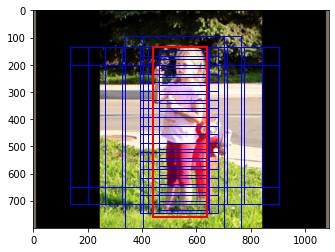

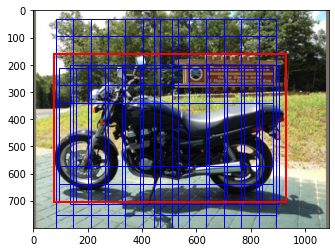

In [ ]:
viz_all_pos(gt_, ground_coord_, images_, model)

### Vizualize Ground Truth at each FPN Level

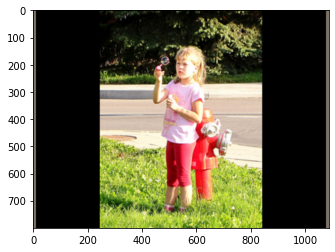

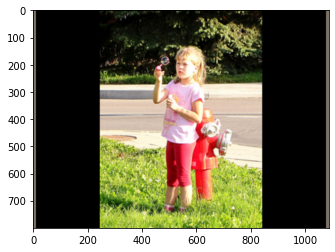

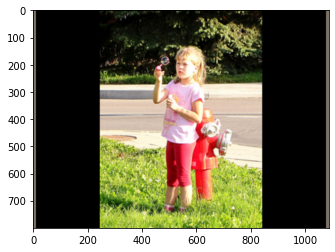

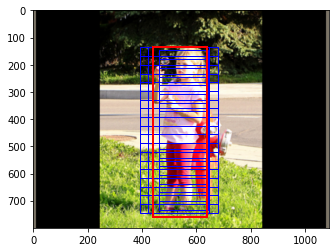

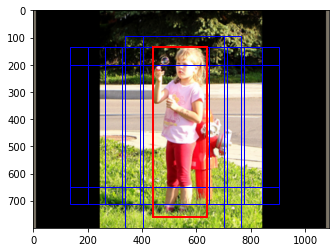

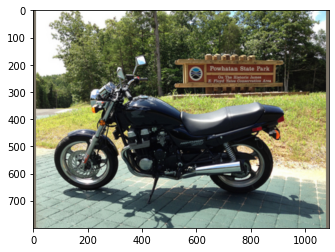

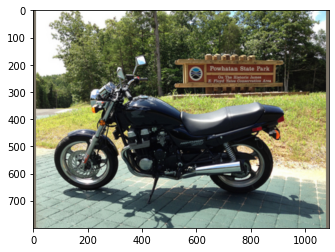

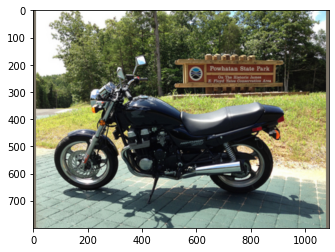

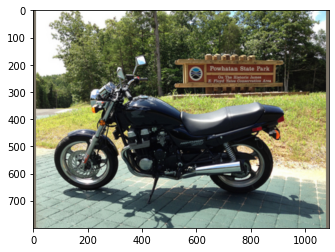

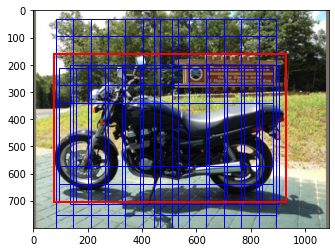

In [ ]:
viz_all_levels(gt_, ground_coord_, images_, model)

### Vizualize Ground Truth at across FPN Levels and Each Aspect ratio

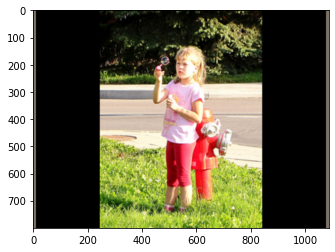

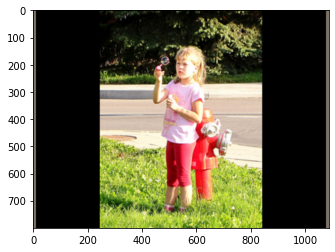

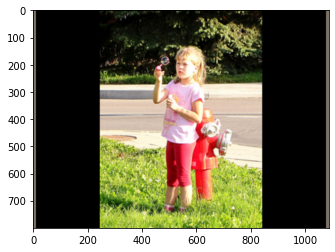

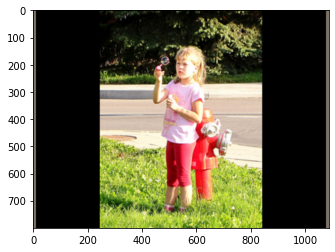

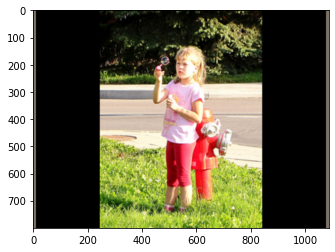

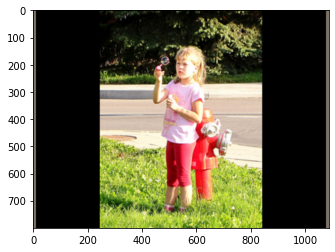

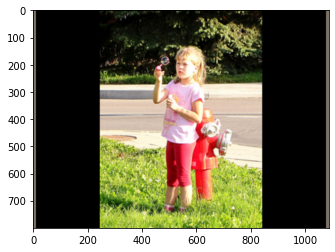

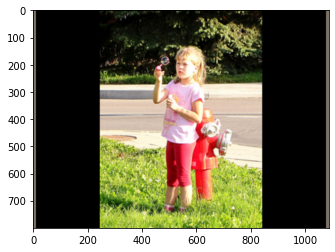

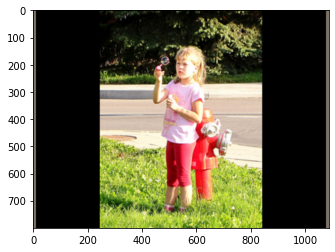

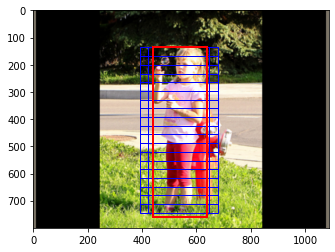

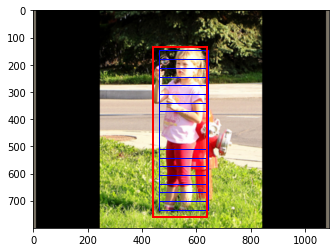

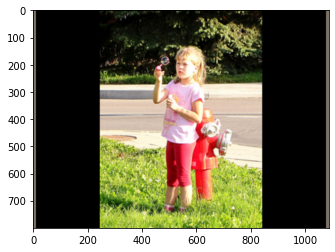

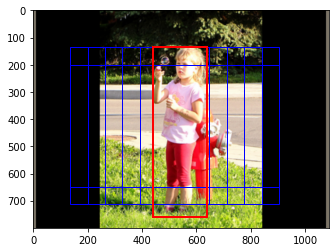

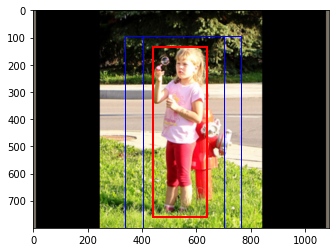

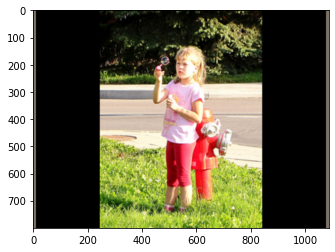

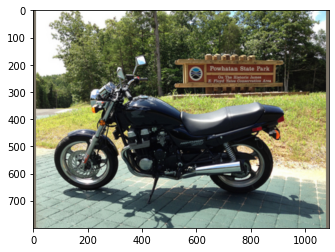

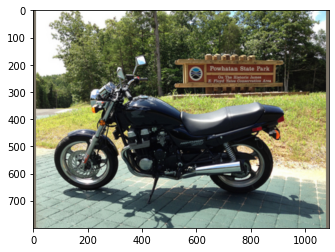

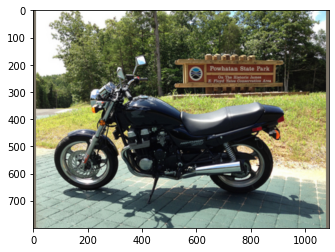

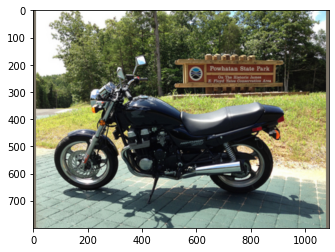

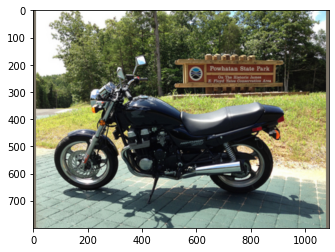

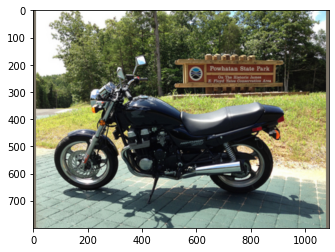

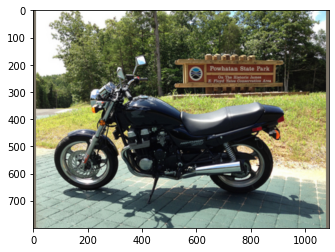

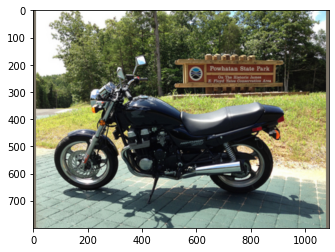

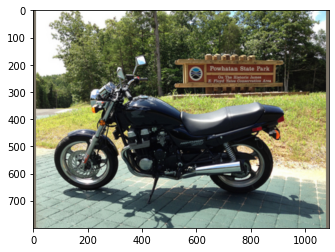

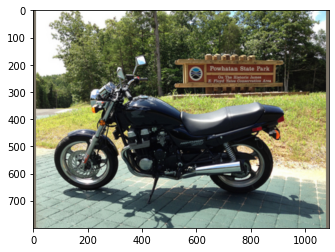

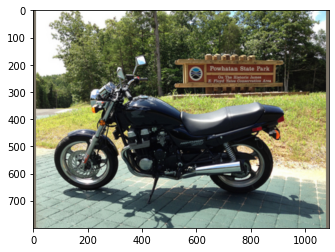

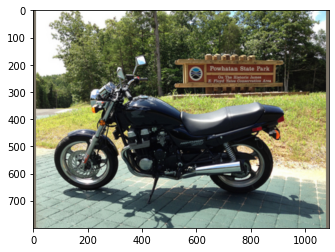

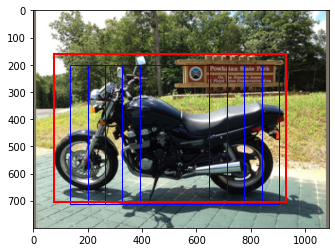

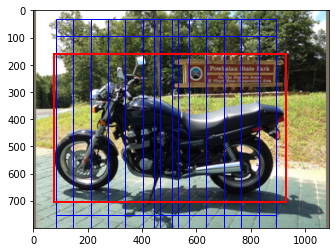

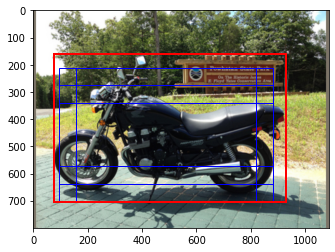

In [ ]:
viz_all_levels_all_asp(gt_, ground_coord_, images_, model)

### Top K results

In [84]:
# After Training 
device='cuda'
model = RPNHead.load_from_checkpoint(checkpoint_path='/content/drive/My Drive/680/Final Project/model_change/epoch=21_Model.ckpt')
model =  model.to(device)

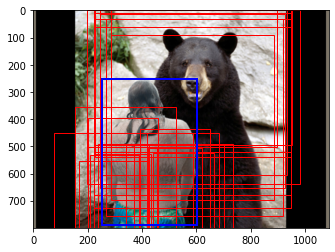

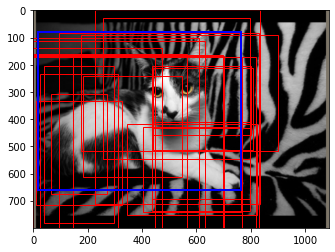

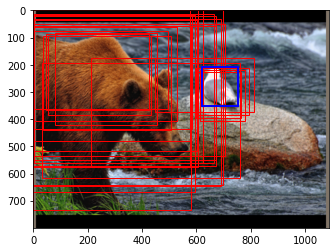

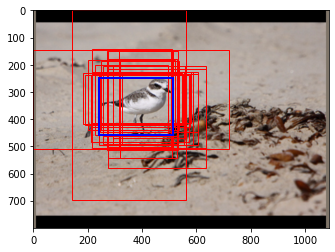

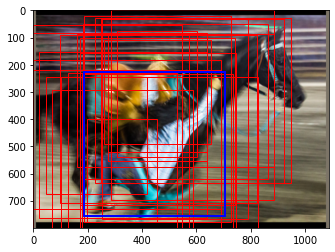

In [68]:
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)

for i in range(5):
  images, labels, bbox, masks, index = next(iter(test_loader))
  images=images.to(device)
  model.topK_plotter(images, bbox[0], 25)

### After NMS

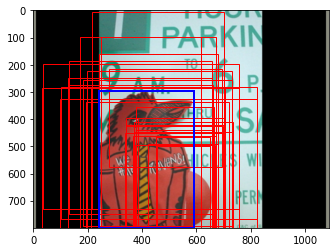

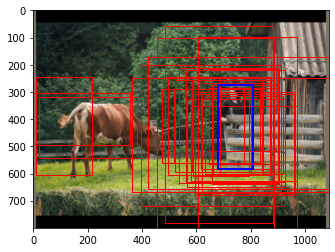

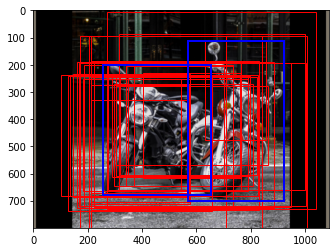

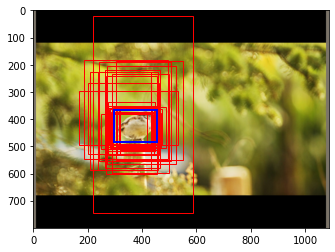

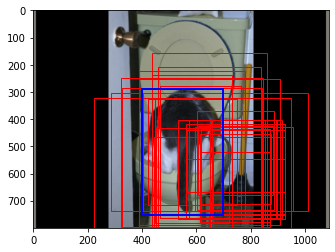

In [87]:
for i in range(5):
  images, labels, bbox, masks, index = next(iter(test_loader))
  images=images.to(device)
  model.nms_plotter(images, bbox[0], 100,30)
  print("================================================================")

### Results: Plots

In [102]:
def plot_graphs():
  # Results from Best Model
  total_loss= [14.30114282610588, 4.71285716388346, 3.968766215612476, 3.746914552601702, 3.4814077061223037, 3.4435925504241203, 3.3180751378831967, 2.2620296880580018, 1.9528310962968363, 1.8210746894660441, 1.7128357175754734, 1.6275236329568656, 1.4575140494254246, 1.435490384104606, 1.4107155204389763, 1.406066450645511, 1.389990477886901, 1.3847154471538334, 1.3697939743423353, 1.348091342079968, 1.3450658471989596, 1.3423586530899017, 1.3427293128569313, 1.3463478181254445, 1.3380302673185767, 1.3390194133585847, 1.336270723896954, 1.341576088465191, 1.3376934311565176, 1.3423412973218087]
  closs=  [0.6942663382493519, 0.396420102124352, 0.3288178213773606, 0.31304351400703784, 0.30138582936495223, 0.3030896992672229, 0.30397709361655467, 0.25812869170569397, 0.23541891943252607, 0.22144016356151808, 0.21213223254037122, 0.20406574084442022, 0.19218595876432612, 0.1948831975231857, 0.1917480586048866, 0.19261352824629105, 0.1904090998457548, 0.18951380963239015, 0.18872479836144135, 0.1900254604028706, 0.1851813735213604, 0.18555267415455845, 0.18523054315878298, 0.18664442837112805, 0.18754877402713868, 0.18753894140864016, 0.18401325614281444, 0.1882066338196123, 0.18879882282374932, 0.188079550609158] 
  rloss= [13.606876569356524, 4.3164370661490175, 3.639948396551299, 3.4338710361929072, 3.180021879318845, 3.140502849590906, 3.0140980409078906, 2.003900997055435, 1.71741217755888, 1.5996345257069944, 1.500703484550187, 1.4234578915020226, 1.265328090655037, 1.2406071859767025, 1.2189674607006002, 1.2134529234553368, 1.1995813768431203, 1.1952016379849653, 1.181069177425656, 1.1580658804562518, 1.159884474829273, 1.156805976803142, 1.1574987696788943, 1.1597033910578827, 1.1504814925547946, 1.151480471444349, 1.1522574657617082, 1.1533694554342793, 1.1488946095839212, 1.1542617441547227]

  total_val_loss=  [5.64405353280747, 5.047386975827932, 4.11677313707655, 4.2729177176040976, 4.162775260228265, 4.057533516067248, 4.483632861109684, 3.4077165414798514, 3.3575821588163346, 3.3184669504471875, 3.319872597306511, 3.3420072976237774, 3.2685540066946537, 3.294315442944156, 3.2910050647703515, 3.301504138048271, 3.3039113701483527, 3.3124244313356708, 3.3012714737781326, 3.2937108648297255, 3.2982722329437184, 3.3277423839321196, 3.301789968385609, 3.287739611000096, 3.3041396224899757, 3.291066804427984, 3.3137795544181032, 3.3028190469523087, 3.3213551737117477, 3.3016370545833484]
  closs_val= [0.46964129185822395, 0.3536829811489546, 0.35144216398671496, 0.3289766578111991, 0.34901060351948127, 0.3362891542118624, 0.3393306220662339, 0.2960021406104532, 0.29369915608567293, 0.27489121782305775, 0.2710294714567767, 0.2866237901453077, 0.2756208463369752, 0.27252743034039706, 0.27855522843470815, 0.28591986970879163, 0.27564154613894104, 0.2816979632305625, 0.2799035741090319, 0.2734213279195654, 0.2878668375102524, 0.26955410243732575, 0.2763650513023411, 0.27404236504722623, 0.27153967731897166, 0.28212531299019855, 0.27628285570542926, 0.2757375344252413, 0.27909456766481067, 0.2801778975999501]
  rloss_val=  [5.174412251247908, 4.693704015253516, 3.7653309744796988, 3.943941065659946, 3.8137646532569094, 3.721244371630001, 4.144302216873985, 3.111714399735862, 3.0638830012866847, 3.0435757345380403, 3.048843128418704, 3.05538351400912, 2.992933152283368, 3.021788014002167, 3.012449841615986, 3.015584266878414, 3.0282698243583015, 3.030726469073456, 3.0213678950381206, 3.0202895354604866, 3.0104053933686075, 3.0581882834799066, 3.025424925650296, 3.013697238052292, 3.0325999493263547, 3.0089414912626284, 3.0374966961892738, 3.0270815129856086, 3.04226061154943, 3.021459156037835]

  # Training Loss vs Epochs
  plt.plot(range(len(total_loss)), total_loss, label="Train Loss")
  plt.plot(range(len(total_val_loss)), total_val_loss, label="Validation Loss")
  plt.title("Epoch Vs Total Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(closs)), closs, label="Train Category Loss")
  plt.plot(range(len(closs_val)), closs_val, label="Validation Category Loss")
  plt.title("Epoch Vs Category Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(rloss)), rloss, label="Train Regressor Loss")
  plt.plot(range(len(rloss_val)), rloss_val, label="Validation Regressor Loss")
  plt.title("Epoch Vs Regressor Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

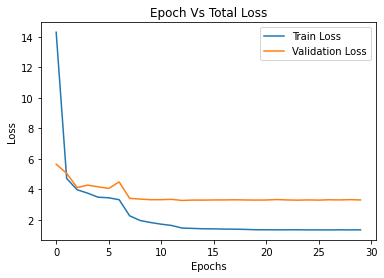

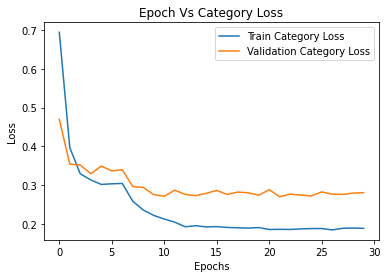

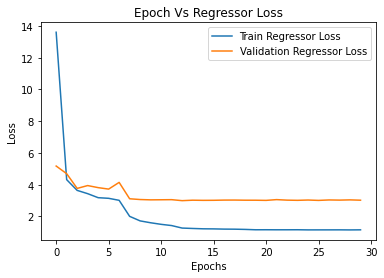

In [103]:
plot_graphs()